In [54]:
import pandas as pd
import numpy as np
import seaborn as sns

In [55]:
df = pd.read_csv('custom_data.csv')
df.head()

,Unnamed: 0,brand,Reg. No.,Engine,Brakes,Tyres,clutch,Body,price
0,1,Honda,XZ-11A-0001,8.8,4.0,7.6,1.4,8.8,30545
1,2,Honda,XX-12B-0002,9.4,6.6,2.2,1.0,4.8,20947
2,3,Honda,XY-13C-0003,6.6,2.2,7.8,6.4,4.8,28467
3,4,Honda,XZ-14D-0004,2.8,1.4,3.8,1.0,5.0,11904
4,5,Honda,XX-15E-0005,5.8,4.2,3.8,5.8,6.4,28402


In [56]:
df.shape

(32648, 9)

In [28]:
df.drop(["Unnamed: 0","Reg. No."],axis=1,inplace=True)

In [29]:
df['brand'].unique()

array(['Honda'], dtype=object)

In [30]:
df.head()

,brand,Engine,Brakes,Tyres,clutch,Body,price
0,Honda,8.8,4.0,7.6,1.4,8.8,30545
1,Honda,9.4,6.6,2.2,1.0,4.8,20947
2,Honda,6.6,2.2,7.8,6.4,4.8,28467
3,Honda,2.8,1.4,3.8,1.0,5.0,11904
4,Honda,5.8,4.2,3.8,5.8,6.4,28402


In [31]:
df.isnull().sum()

brand     0
Engine    0
Brakes    0
Tyres     0
clutch    0
Body      0
price     0
dtype: int64

<AxesSubplot:>

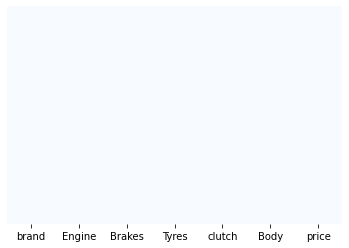

In [32]:

sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [33]:
# Perform One-Hot Encoding for "Make", "Model", "Type", "Origin", and "DriveTrain"
df = pd.get_dummies(df, columns=["brand"])

In [34]:
df.head()

,Engine,Brakes,Tyres,clutch,Body,price,brand_Honda
0,8.8,4.0,7.6,1.4,8.8,30545,1
1,9.4,6.6,2.2,1.0,4.8,20947,1
2,6.6,2.2,7.8,6.4,4.8,28467,1
3,2.8,1.4,3.8,1.0,5.0,11904,1
4,5.8,4.2,3.8,5.8,6.4,28402,1


In [44]:
df.shape

(32648, 7)

In [36]:
# Feeding input features to X and output (MSRP) to y
X = df.drop("price", axis = 1)
y = df["price"]

In [37]:
# Convert the datatype to float32 (to run Linear Learner successfully)
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2)

In [38]:
# Boto3 is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python
# Boto3 allows Python developer to write software that makes use of services like Amazon S3 and Amazon EC2

import sagemaker
import boto3

# Let's create a Sagemaker session
sagemaker_session = sagemaker.Session()

# Let's define the S3 bucket and prefix that we want to use in this session
# bucket = 'aws-ml-10days' # bucket named 'aws-ml-10days' was created beforehand

bucket = sagemaker_session.default_bucket() 
prefix = 'linear_learner' # prefix is the subfolder within the bucket.

# Let's get the execution role for the notebook instance. 
# This is the IAM role that you created when you created your notebook instance. You pass the role to the training job.
# Note that AWS Identity and Access Management (IAM) role that Amazon SageMaker can assume to perform tasks on your behalf (for example, reading training results, called model artifacts, from the S3 bucket and writing training results to Amazon S3). 
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::920644990528:role/mlops


In [39]:
import io # The io module allows for dealing with various types of I/O (text I/O, binary I/O and raw I/O). 
import numpy as np
import sagemaker.amazon.common as smac # sagemaker common libary

# Code below converts the data in numpy array format to RecordIO format
# This is the format required by Sagemaker Linear Learner 

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0) 
# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 


0

In [40]:
import os

# Code to upload RecordIO data to S3
 
# Key refers to the name of the file    
key = 'linear-train-data'

# The following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-us-east-1-920644990528/linear_learner/train/linear-train-data


In [41]:
# create an output placeholder in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-920644990528/linear_learner/output


In [42]:
# Note that this code leverages the new SageMaker SDK 2.0
# Check this for the list of changes from AWS SageMaker SDK 1.0 to 2.0: https://sagemaker.readthedocs.io/en/stable/v2.html

# This code is used to get the training container of sagemaker built-in algorithms
# all we have to do is to specify the name of the algorithm that we want to use

# Let's obtain a reference to the linearLearner container image
# Note that all regression models are named estimators
# You don't have to specify (hardcode) the region, get_image_uri will get the current region name using boto3.Session
container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)


# This is using the old AWS SageMAker SDK 1.0 (You need to use get_image_uri and note that attribute order is different as well)
# from sagemaker.amazon.amazon_estimator import get_image_uri
# container = get_image_uri(boto3.Session().region_name, 'linear-learner')

In [45]:
# We have pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 
# We can also specify how many instances we would like to use for training

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)


# We can tune parameters like the number of features that we are passing in, type of predictor like 'regressor' or 'classifier', mini batch size, epochs
# Train 32 different versions of the model and will get the best out of them (built-in parameters optimization!)

linear.set_hyperparameters(feature_dim = 6,
                           predictor_type = 'regressor',
                           mini_batch_size = 10,
                           epochs = 10,
                           num_models = 32,
                           loss = 'absolute_loss')

# Now we are ready to pass in the training data from S3 to train the linear learner model

linear.fit({'train': s3_train_data})

# Let's see the progress using cloudwatch logs

2022-12-09 08:14:40 Starting - Starting the training job...ProfilerReport-1670573679: InProgress
...
2022-12-09 08:15:38 Starting - Preparing the instances for training...............
2022-12-09 08:18:09 Downloading - Downloading input data.........
2022-12-09 08:19:38 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/09/2022 08:19:26 INFO 140314378520384] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margi

In [46]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer


linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge',
                                 serializer=CSVSerializer(),
                                 deserializer=JSONDeserializer())

--------!

In [47]:
# making prediction on the test data

result = linear_regressor.predict(X_test)

In [48]:
# Since the result is in json format, we access the scores by iterating through the scores in the predictions

predictions = np.array([r['score'] for r in result['predictions']])

In [49]:
predictions

array([21012.50585938, 37014.21484375, 18695.27539062, ...,
       34655.66796875, 20609.55859375, 20244.55859375])

In [50]:
predictions.shape

(6530,)

In [51]:
y_test.shape

(6530,)

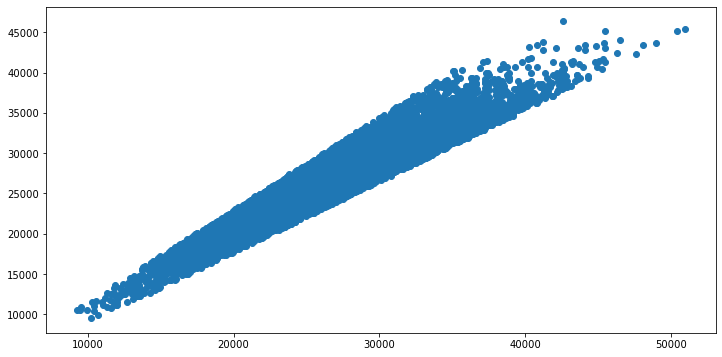

In [53]:
import matplotlib.pyplot as plt
# Visualize how accurate predictions are relative to y_test
plt.figure(figsize = (12, 6))
plt.scatter(y_test, predictions)